In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns

In [2]:
import graphviz
import pydot

Notebook kan være lidt en røv med JavaScript, men det her initialiserer en JS-instans

In [3]:
shap.initjs()

## SØPØLSER!!!

I dag skal vi kigge på muslinger - det er underligt... men også lidt fedt.

DATA!

In [4]:
data = pd.read_csv("abalone.csv",
                  names=["Køn","Længde","Diameter","Højde",
                         "Helvægt","Vægt_u_skal",
                         "Smat_vægt","Skal_vægt",
                         "Ringe"])

In [5]:
data.head()

,Køn,Længde,Diameter,Højde,Helvægt,Vægt_u_skal,Smat_vægt,Skal_vægt,Ringe
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'Helvægt')

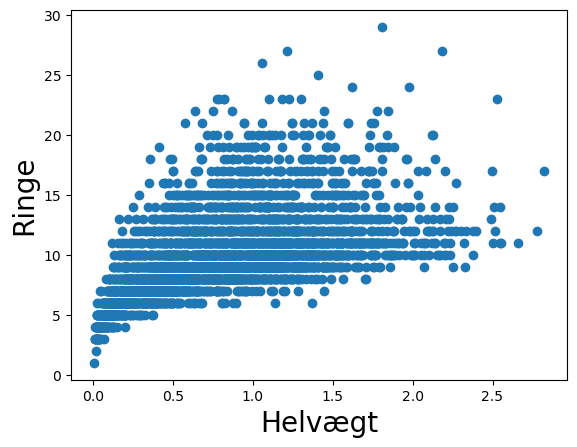

In [6]:
plt.scatter(data['Helvægt'],data['Ringe'])
plt.ylabel('Ringe',size=20)
plt.xlabel('Helvægt',size=20)

Text(0.5, 0, 'Køn')

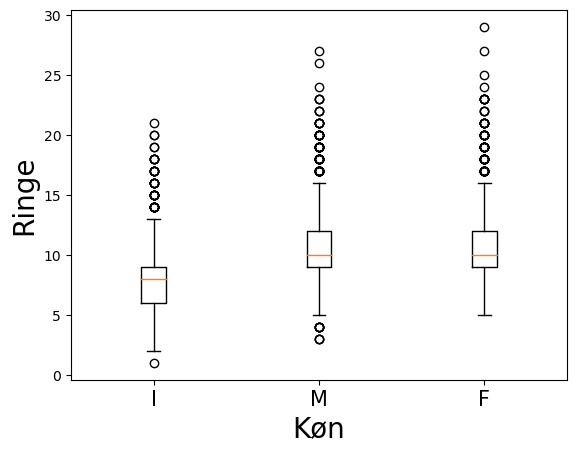

In [7]:
plt.boxplot(data[data.Køn=='I']['Ringe'],positions=[1])
plt.boxplot(data[data.Køn=='M']['Ringe'],positions=[2])
plt.boxplot(data[data.Køn=='F']['Ringe'],positions=[3]) 

plt.xticks(ticks=[1,2,3],labels=['I', 'M', 'F'],size= 15)
plt.ylabel('Ringe',size=20)
plt.xlabel('Køn',size=20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

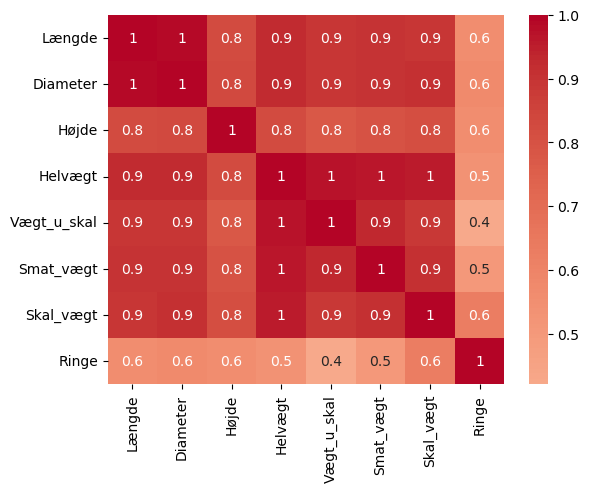

In [8]:
cont = ["Køn","Længde","Diameter","Højde",
                         "Helvægt","Vægt_u_skal",
                         "Smat_vægt","Skal_vægt",
                         "Ringe"]
corr_matrix = pd.DataFrame(data[cont],columns=cont).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center = 0,
            annot=True,
            fmt='.1g')

Hurtig split i X og Y:

In [9]:
y = data['Ringe']
X = data[["Køn","Længde","Højde",
          "Vægt_u_skal","Smat_vægt","Skal_vægt"]]

Hurtig dummyficering af kategoriske variable, så de ligger hver for sig:

In [10]:
X['Køn.M'] = [1 if s == 'M' else 0 for s in X['Køn']]
X['Køn.F'] = [1 if s == 'F' else 0 for s in X['Køn']]
X['Køn.I'] = [1 if s == 'I' else 0 for s in X['Køn']]
X = X.drop('Køn', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
X.head()

,Længde,Højde,Vægt_u_skal,Smat_vægt,Skal_vægt,Køn.M,Køn.F,Køn.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


Vi bruger en meget simpel model kaldet: "Extreme Gradient Boosting". Modellen er ikke super vigtig, men det er en model der hører ind under "træ-familien".

In [12]:
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Hvordan ser vores model ud i forhold til faktisk Y?

Text(0.5, 0, 'Actual')

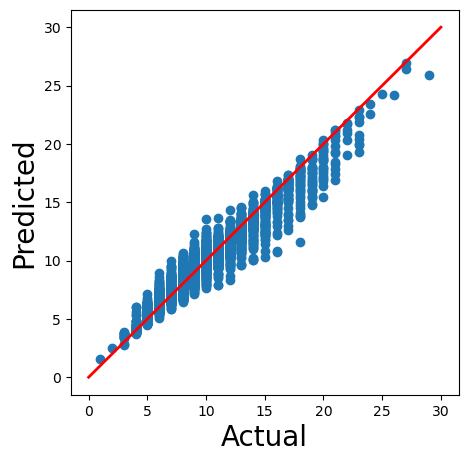

In [13]:
y_pred = model.predict(X)

#Model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y,y_pred)
plt.plot([0, 30], 
         [0, 30], 
         color='r', 
         linestyle='-', 
         linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

Vi kan fortolke denne model ved hjælp af SHAP-værdier. For at gøre dette, passer vi vores model ind i SHAP Explainer-funktionen (linje 2). Dette skaber et explainer-objekt. Vi bruger dette til at beregne SHAP-værdier for hver observation i featurematricen.

In [14]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Der er 8 SHAP-værdier for hver af de 4.177 observationer i featurematricen. Det er én SHAP-værdi for hver feature i vores model. Vi kan bruge vandfaldsfunktionen til at visualisere SHAP-værdierne af den første observation

In [15]:
np.shape(shap_values.values)

(4177, 8)

E[f(x)] = 9.933 giver det gennemsnitlige forudsagte antal ringe på tværs af alle 4.177 søpølser. f(x) = 13.043 er det forudsagte antal ringe for denne specifikke søpølse. SHAP-værdierne er alle værdierne imellem. For eksempel har vægt_u_skal øget det forudsagte antal ringe med 1,68.

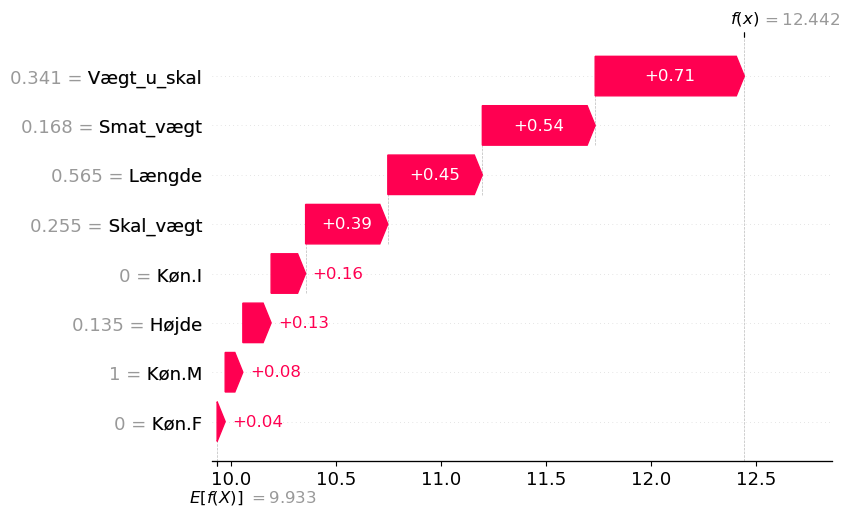

In [25]:
shap.plots.waterfall(shap_values[90])

Et SHAP-vandfaldsdiagram, der viser features bidrag til det forudsagte antal ringe for den første observation. Der vil være et unikt vandfaldsdiagram for hver observation/søpølse i vores datasæt. De kan alle fortolkes på samme måde som ovenfor. I hvert tilfælde fortæller SHAP-værdierne os, hvordan features har bidraget til forudsigelsen sammenlignet med den gennemsnitlige forudsigelse. Store positive/negative værdier indikerer, at featuren havde en betydelig indvirkning på modellens forudsigelse.

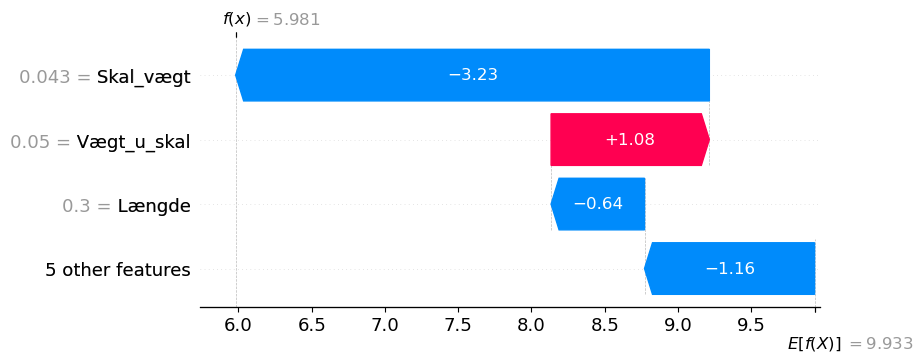

In [33]:
shap.plots.waterfall(shap_values[900], max_display=4)

Det samme, men komprimeret i en mindre figur

In [26]:
shap.plots.force(shap_values[0])

Vandfalds- og force plots er gode til at fortolke individuelle forudsigelser. For at forstå, hvordan vores model generelt laver forudsigelser, skal vi aggregere SHAP-værdierne. En måde at gøre dette på er ved at bruge et stakket-force plot.

Vi kan kombinere flere force plots sammen for at skabe et stakket force plot. Her passer vi SHAP-værdierne for de første 100 observationer i force plot-funktionen. Hvert enkelt force plot er nu lodret og stakket side om side.

Nedenfor kan vi vælge "skal_vægt" som bliver X-aksen og "skal_vægt effects" som Y. Her kan vi se, hvordan skallens vægt betyder en del for at sige noget om alder - jo lettere skal, jo kraftigere prædikterer den en ung alder.

In [27]:
shap.plots.force(shap_values[0:100])

For hver feature beregner vi den gennemsnitlige SHAP-værdi på tværs af alle observationer. Specifikt tager vi gennemsnittet af de absolutte værdier, da vi ikke vil have, at positive og negative værdier skal modvirke hinanden. Til sidst får vi søjlediagrammet nedenfor. Der er en søjle for hver feature. For eksempel kan vi se, at skalvægt havde den største gennemsnitlige SHAP-værdi.

Features, der har gjort store positive/negative bidrag, vil have en stor gennemsnitlig SHAP-værdi. Med andre ord er det de features, der har haft en betydelig indvirkning på modellens forudsigelser. I denne forstand kan dette plot bruges på samme måde som et feature vigtighedsplot.

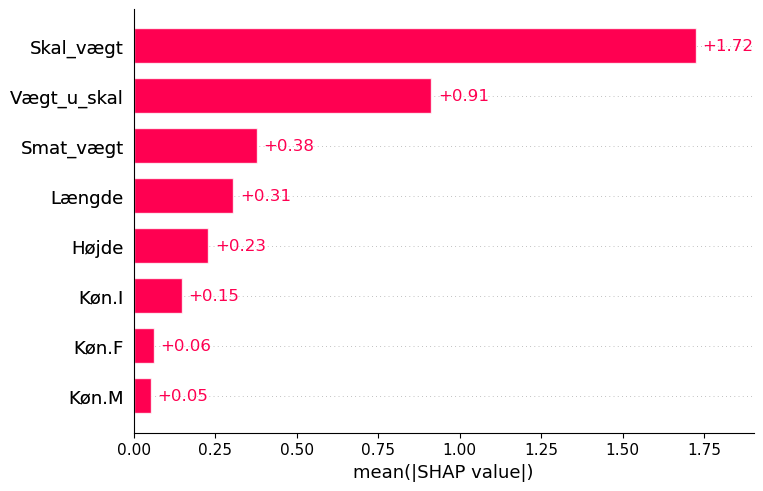

In [20]:
shap.plots.bar(shap_values)

Beeswarm-plottet visualiserer alle SHAP-værdierne. På y-aksen er værdierne grupperet efter feature. For hver gruppe bestemmes farven på punkterne af featureværdien (dvs. højere featureværdier er rødere).

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


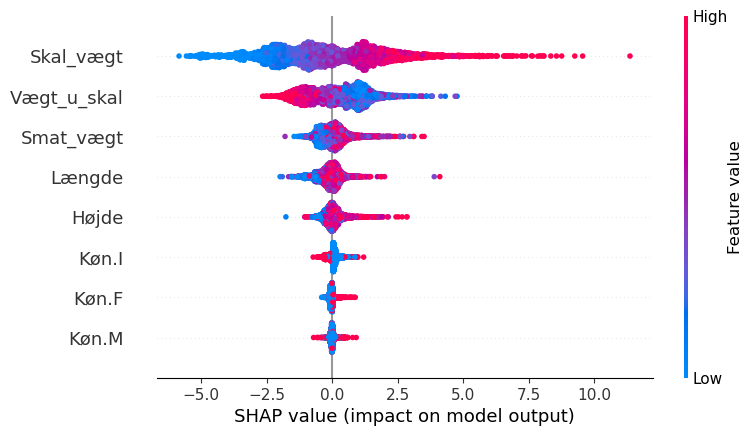

In [21]:
shap.plots.beeswarm(shap_values)

Vi kan også kigge på enkelte SHAP-værdier i forhold til enkelte features:

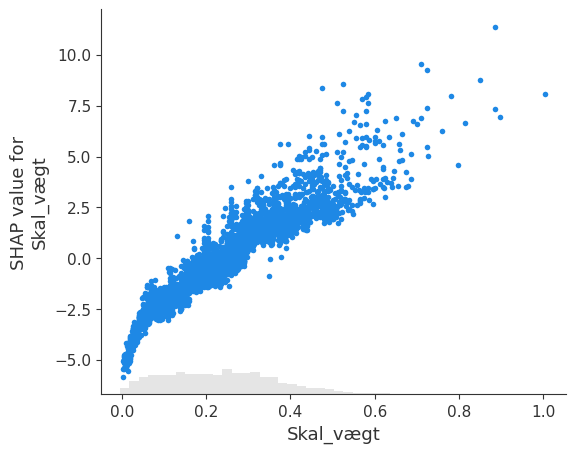

In [22]:
shap.plots.scatter(shap_values[:,"Skal_vægt"])

In [4]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

In [5]:
y = df.pop('target')

In [6]:
list_numerical = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']

X = df[list_numerical]

Hvad er det?

- Age = Alder
- Thalac = Maksimal puls ved motion
- Trestbps = Hvilepuls
- Chol = kolesterol
- Oldpeak = Ændring i hjerte ved motion

In [7]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [8]:
X_upsampled, y_upsampled = smote.fit_resample(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [ ]:
X_train

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [13]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

In [14]:
model.fit(X_train, y_train, 
             epochs=15, 
             batch_size=13,
             validation_data=(X_test, y_test)
             )

Epoch 1/15
28/28 [==============================] - 1s 9ms/step - loss: 0.6768 - accuracy: 0.6335 - val_loss: 0.6735 - val_accuracy: 0.6591
Epoch 2/15
28/28 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.7244 - val_loss: 0.6523 - val_accuracy: 0.6932
Epoch 3/15
28/28 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.7415 - val_loss: 0.6340 - val_accuracy: 0.6932
Epoch 4/15
28/28 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.7443 - val_loss: 0.6150 - val_accuracy: 0.7045
Epoch 5/15
28/28 [==============================] - 0s 3ms/step - loss: 0.5855 - accuracy: 0.7415 - val_loss: 0.5989 - val_accuracy: 0.6932
Epoch 6/15
28/28 [==============================] - 0s 3ms/step - loss: 0.5657 - accuracy: 0.7415 - val_loss: 0.5850 - val_accuracy: 0.6932
Epoch 7/15
28/28 [==============================] - 0s 3ms/step - loss: 0.5455 - accuracy: 0.7472 - val_loss: 0.5754 - val_accuracy: 0.7045
Epoch 8/15
28/28 [==

In [15]:
explainer = shap.KernelExplainer(model.predict,X_train)

11/11 [==============================] - 0s 925us/step


Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [16]:
shap_values = explainer.shap_values(X_test,nsamples=100)

  0%|          | 0/88 [00:00<?, ?it/s]

330/330 [==============================] - 0s 863us/step


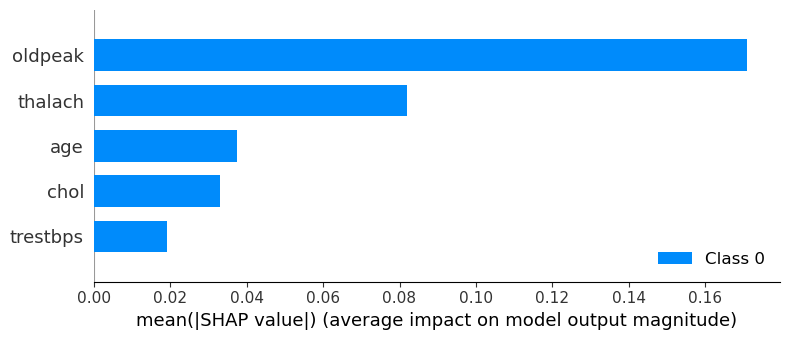

In [17]:
shap.summary_plot(shap_values,X_test)

In [18]:
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])

In [19]:
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)

In [20]:
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[20,:])

In [21]:
shap_values50 = explainer.shap_values(X_train.iloc[50:100,:], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
shap.force_plot(explainer.expected_value, shap_values50[0], X_train.iloc[50:100,:])